<h1>Twitter Streaming Assignment</h1>
In this assignment, you need to calculate the average sentiment of selected tweets and draw a dynamic graph that shows how this average sentiment is changing over time. Roughly, you need to:

<li>create a twitter stream listener</li>
<li>collect tweets in batches</li>
<li>get the sentiment associated with each tweet</li>
<li>create windows on the stream</li>
<li>calculate the average sentiment within each window</li>
<li>create a dynamic graph that updates every x seconds with the window time on the x axis and the average sentiment in the window on the y-axis</li>

<h2>The graph</h2>
<li>Note that the graph will pop up in a separate window</li>
<li>Which may be behind your browser - so look for it!</li>


<h2>Resources required</h2>
<li><span style="color:blue">streaming twitter</span>: based on the java twitter library <span style="color:blue">twitter4j</span>, this library provides Spark streaming support for twitter</li>
<li><span style="color:blue">stanford corenlp</span>: for the sentiment analysis</li>
<li><span style="color:blue">JFree Chart</span>: a java library for drawing charts (<a href="http://www.jfree.org/jfreechart/">http://www.jfree.org/jfreechart/</a></li>

<h1>init spark</h1>
<li>The driver_memory step is important since streaming apps take up a lot of memory</li>
<li>A few new jars:</li>
<ul>
    <li>twitter streaming api jar</li>
    <li>jfreechart jars for drawing charts</li>
</ul>

In [1]:
%%init_spark
launcher.num_executors = 2
launcher.executor_cores = 2
launcher.driver_memory = '4g'
launcher.jars =["/Users/hardeepjohar/Documents/Courses/Spring2020/AnalyticsOnTheCloud/class12/jars/stanford-corenlp-3.9.2-models.jar","/Users/hardeepjohar/Documents/Courses/Spring2020/AnalyticsOnTheCloud/class12/jars/stanford-corenlp-3.9.2.jar",
               "/Users/hardeepjohar/Downloads/jfreechart-1.0.19/lib/jcommon-1.0.23.jar",
               "/Users/hardeepjohar/Downloads/jfreechart-1.0.19/lib/jfreechart-1.0.19.jar"]
launcher.packages= ["databricks:spark-corenlp:0.4.0-spark2.4-scala2.11", "org.apache.bahir:spark-streaming-twitter_2.11:2.4.0"]


<h2>CoreNLP imports</h2>

In [1]:
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame



Intitializing Scala interpreter ...

Spark Web UI available at http://DESKTOP-RME8VLI.home:4041
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1588963464505)
SparkSession available as 'spark'


import java.util.Properties
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame


<h2>Write the program</h2>
<li><b>NOTE:</b> Because Spark is a distributed computing platform, objects are <span style="color:red">serialized</span>. Serialization is a complex thing but the 5 second version is that objects (data + methods) must be distributable and the result of the distribution should not depend on the sequence of completion of distributed parts of the object (this should make sense). As a result, if you call functions or rdds that are outside the scope of a cell, Spark may not be able to serialize the code (the program object). You should grow your code organically - i.e., as the code grows, include all previous parts of the code in the same cell.</li>
<li>Note that this is an artifact of Jupyter. Cells are independent and scope is therefore murky. In a single program, this would not be an issue (a single program is like a one cell jupyter notebook!)</li>

<h2>Parameters</h2>
<li><span style="color:blue">BATCH_SIZE</span>: The size of a micro batch</li>
<li><span style="color:blue">NUM_BATCHES</span>: The minumum amount of data you need to collect. Ideally, of course, this should run for ever!</li>
<li><span style="color:blue">WINDOW_LENGTH</span>: The size of a window. We're collecting data in small batches, a window in this instance is like constructing a moving average. Roughly, we're collecting a moving 5 minute moving average of data averaged every minute</li>
<li><span style="color:blue">SLIDE_DURATION</span>: The slide duration. Since we're reproducing a moving average, we'll keep this at the batch size</li>
<li><span style="color:blue">TWEET_WORDS</span>: The tweets we will examine. Each tweet in our moving average should contain at least one word from this list</li>


<h3>Note</h3>
I suggest you start with a NUM_BATCHES of 5, BATCH_SIZE or 20, WINDOW_LENGTH of 60, and an empty array of TWEET_WORDS. That way you'll be sure to get some initial data to test out your code

In [37]:
val BATCH_SIZE = 20
val NUM_BATCHES = 5
val WINDOW_LENGTH =60
val SLIDE_DURATION = BATCH_SIZE

//The apple keywords will work better during market hours (9:30 to 4:00 EDT)
//val tweet_words = Array("aapl","apple","mac","ipad","iphone")
val TWEET_WORDS = Array()

BATCH_SIZE: Int = 20
NUM_BATCHES: Int = 5
WINDOW_LENGTH: Int = 60
SLIDE_DURATION: Int = 20
TWEET_WORDS: Array[Nothing] = Array()


<h2>getSentiment</h2>
<li>A function that returns the sentiment given a piece of text</li>
<li>Get the sentence for each sentence in the text and divide by the number of sentences</li>
<li>(This is the stanford corenlp part!)
<li>Returns a Double</li>


In [14]:

def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map { sent => 
        val tree = sent.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score = RNNCoreAnnotations.getPredictedClass(tree)
        score
    }
    score.sum/sentences.length.toFloat

}

getSentiment: (text: String)Double


In [15]:
getSentiment("John Gilpin was a citizen of credit and renown. A train band captian eke was he of famous london town.")

//Should return: Double = 2.5

res3: Double = 2.5


<h2>filterData</h2>
<li>Write a function filterData that takes a text string, and an array of word strings as arguments and returns true or false</li>
<li>It should return true if <span style="color:red">any</span> of the words in the array are in the string</li>


In [29]:
def filterData(text: String,words: Array[String]): Boolean = words.exists(text.contains)


filterData: (text: String, words: Array[String])Boolean


In [31]:
var r1 = filterData("Coronavirus has hit New York City in the worst way possible. USA has the highest incidence of COVID-19",
          Array("Corona","infection"))
val r2 = filterData("Coronavirus has hit New York City in the worst way possible. USA has the highest incidence of COVID-19",
          Array("Apple","APPL"))

/* Should return:
r1: Boolean = true
r2: Boolean = false
*/


r1: Boolean = true
r2: Boolean = false


<h2>Twitter keys</h2>
<li>Get twitter API keys <a href="https://developer.twitter.com/en/docs/basics/getting-started">Getting started with twitter API</a> (use the standard API)</li>
<li>Enter them below</li>
<li>Then assign them to various twitter4j objects</li>
<li>Finally, create the stream receiver</li>

In [32]:
val CONSUMER_KEY = ""
val CONSUMER_SECRET = ""
val ACCESS_TOKEN = ""
val ACCESS_TOKEN_SECRET = ""

CONSUMER_KEY: String = EX2Gnd3mkKLnWpc8sbcf6a5ZH
CONSUMER_SECRET: String = 735TnoWCvBofLAEWdGQOtuqMVzC2JXMyXmpwDxAbG6ChCp403Q
ACCESS_TOKEN: String = 2604997424-8rDmLSXai5TXiWY25J9zD831y8IoZTiuE1Jgk1Z
ACCESS_TOKEN_SECRET: String = caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d


In [35]:
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)

res18: String = caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d


<h2>Set up a streaming context with batch size BATCH_SIZE</h2>
<li>From now on, to be on the safe (serializable!) side, include all the above code in every cell)</li>
<li>create a stream listener</li>
<li>create a tweets variable to get the tweets from the listener</li>
<li>Done for you!</li>

In [38]:
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))
val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")

import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
ssc: org.apache.spark.streaming.StreamingContext = org.apache.spark.streaming.StreamingContext@3d31c1b4
stream: org.apache.spark.streaming.dstream.ReceiverInputDStream[twitter4j.Status] = org.apache.spark.streaming.twitter.TwitterInputDStream@49d902f2
tweets: org.apache.spark.streaming.dstream.DStream[twitter4j.Status] = org.apache.spark.streaming.dstream.FilteredDStream@116a1f92



<h3>Create a DStream with <span style="color:blue">(text,sentiment)</span> pairs</h3>
<li>the function, getText, returns the text of a tweet</li>
<li>not necessary here but the function getHashTagEntities gets all the hash tags associated with a tweet</li>
<li>Note: You will need to include the getSentiment function in this cell</li>
<li>Also many other functions (retweets, etc.)</li>

In [ ]:
//All imports
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.{Annotation, StanfordCoreNLP}
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame

//All parameters
val BATCH_SIZE = 20
val NUM_BATCHES = 20
val WINDOW_LENGTH = 60
val SLIDE_DURATION = 40

//getSentiment function

def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map { sent => 
        val tree = sent.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score = RNNCoreAnnotations.getPredictedClass(tree)
        score
    }
    score.sum/sentences.length.toFloat

}

//val words = Array("covid","corona","virus")
val words = Array("aapl","apple","mac","ipad","iphone")

//filterData function
def filterData(text: String,words: Array[String]): Boolean = words.exists(text.contains)

//Twitter API keys

val CONSUMER_KEY = "EX2Gnd3mkKLnWpc8sbcf6a5ZH"
val CONSUMER_SECRET = "735TnoWCvBofLAEWdGQOtuqMVzC2JXMyXmpwDxAbG6ChCp403Q"
val ACCESS_TOKEN = "2604997424-8rDmLSXai5TXiWY25J9zD831y8IoZTiuE1Jgk1Z"
val ACCESS_TOKEN_SECRET = "caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d"

//Twitter API keys attached to twitter4j
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)


//Streaming context and twitter stream set up
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))

val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")


//text_sentiment_pairs
val text_sentiment_pairs = tweets.map(i => (i.getText, getSentiment(i.getText)))


<h3>Filter the text_sentiment_array to include only tweets with words in our TWEET_WORDS array</h3>
<li>Also, throw away the text (i.e., return a DStream of Double)</li>
<li>Save this in an DStream of Double <span style="color:blue">sentiment_array</span></li>

In [ ]:
//All imports
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame

//All parameters
val BATCH_SIZE = 20
val NUM_BATCHES = 20
val WINDOW_LENGTH = 60
val SLIDE_DURATION = 40

//getSentiment function

def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map { sent => 
        val tree = sent.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score = RNNCoreAnnotations.getPredictedClass(tree)
        score
    }
    score.sum/sentences.length.toFloat

}

//val words = Array("covid","corona","virus")
val words = Array("aapl","apple","mac","ipad","iphone")

//filterData function
def filterData(text: String,words: Array[String]): Boolean = words.exists(text.contains)

//Twitter API keys

val CONSUMER_KEY = "EX2Gnd3mkKLnWpc8sbcf6a5ZH"
val CONSUMER_SECRET = "735TnoWCvBofLAEWdGQOtuqMVzC2JXMyXmpwDxAbG6ChCp403Q"
val ACCESS_TOKEN = "2604997424-8rDmLSXai5TXiWY25J9zD831y8IoZTiuE1Jgk1Z"
val ACCESS_TOKEN_SECRET = "caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d"

//Twitter API keys attached to twitter4j
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)


//Streaming context and twitter stream set up
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))

val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")


//text_sentiment_pairs
val text_sentiment_pairs = tweets.map(i => (i.getText, getSentiment(i.getText)))



//sentiment_array
val sentiment_array = text_sentiment_pairs.filter(i => filterData(i._1, words)).map(t => t._2)



<h3>sentiment_window</h3>
<li>Create a window of length WINDOW_DURATION and slide SLIDE_DURATION</li>
<li>Note that you can use reduceByWindow and countByWindow if you like to compute averages and, in that case, most of the remaining steps will be different for you</li>
<li>I find this more straight forward</li>

In [ ]:
//All imports
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame

//All parameters
val BATCH_SIZE = 20
val NUM_BATCHES = 20
val WINDOW_LENGTH = 60
val SLIDE_DURATION = 40

//getSentiment function

def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map { sent => 
        val tree = sent.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score = RNNCoreAnnotations.getPredictedClass(tree)
        score
    }
    score.sum/sentences.length.toFloat

}

//val words = Array("covid","corona","virus")
val words = Array("aapl","apple","mac","ipad","iphone")

//filterData function
def filterData(text: String,words: Array[String]): Boolean = words.exists(text.contains)

//Twitter API keys

val CONSUMER_KEY = "EX2Gnd3mkKLnWpc8sbcf6a5ZH"
val CONSUMER_SECRET = "735TnoWCvBofLAEWdGQOtuqMVzC2JXMyXmpwDxAbG6ChCp403Q"
val ACCESS_TOKEN = "2604997424-8rDmLSXai5TXiWY25J9zD831y8IoZTiuE1Jgk1Z"
val ACCESS_TOKEN_SECRET = "caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d"

//Twitter API keys attached to twitter4j
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)


//Streaming context and twitter stream set up
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))

val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")


//text_sentiment_pairs
val text_sentiment_pairs = tweets.map(i => (i.getText, getSentiment(i.getText)))



//sentiment_array
val sentiment_array = text_sentiment_pairs.filter(i => filterData(i._1, words)).map(t => t._2)



//Window definition
val sentiment_window = sentiment_array.window(Seconds(WINDOW_LENGTH), Seconds(SLIDE_DURATION))



<h3>Create and update an array that holds the moving average</h3>
<li>for each window, we will report the average sentiment in that window (all tweet sentiments/number of tweets) - note that this is not exactly a moving average in time terms</li>
<li>the main reason for doing this is that we may not get tweets in every window and then will have to deal with nans. Too complicated!</li>
<li>The method below is:
    <ul>
        <li>sentiment_window contains the sentiment of each tweet in the window</li>
        <li>using foreachRDD, and a function getAverages, calculate the average sentiment for that window</li>
        <li>getAverage should calculate (timestamp, sentiment) pair for each window<li>
        <li>and add this to the ArrayBuffer</li>
    </ul>
    <li>You also need to clean the timestamp. Convert it into a string, drop the "ms" from the end, and then drop everything other than last 7 digits</li>
    <li>You might find the function <span style="color:blue">takeRight</span> useful</li>
    <li><b>Note</b>: Bear in mind that while DStream objects do not persist, Scala objects, RDDs, etc. do persist. Once the stream stops, these non-DStream objects are still accessible in your program</li>

In [1]:
//All imports
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame

//All parameters
// val BATCH_SIZE = 20
// val NUM_BATCHES = 20
// val WINDOW_LENGTH = 60
// val SLIDE_DURATION = 40

val BATCH_SIZE = 20
val NUM_BATCHES = 5
val WINDOW_LENGTH =60
val SLIDE_DURATION = BATCH_SIZE

//getSentiment function

def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map { sent => 
        val tree = sent.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score = RNNCoreAnnotations.getPredictedClass(tree)
        score
    }
    score.sum/sentences.length.toFloat

}

//val words = Array("covid","corona","virus")
val words = Array("aapl","apple","mac","ipad","iphone")
// val words = Array()

//filterData function
def filterData(text: String,words: Array[String]): Boolean = words.exists(text.contains)

//Twitter API keys

val CONSUMER_KEY = "EX2Gnd3mkKLnWpc8sbcf6a5ZH"
val CONSUMER_SECRET = "735TnoWCvBofLAEWdGQOtuqMVzC2JXMyXmpwDxAbG6ChCp403Q"
val ACCESS_TOKEN = "2604997424-8rDmLSXai5TXiWY25J9zD831y8IoZTiuE1Jgk1Z"
val ACCESS_TOKEN_SECRET = "caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d"

//Twitter API keys attached to twitter4j
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)


//Streaming context and twitter stream set up
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))

val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")

//text_sentiment_pairs
val text_sentiment_pairs = tweets.map(i => (i.getText, getSentiment(i.getText)))

//sentiment_array
val sentiment_array = text_sentiment_pairs.filter(i => filterData(i._1, words)).map(t => t._2)

//Window definition
val sentiment_window = sentiment_array.window(Seconds(WINDOW_LENGTH), Seconds(SLIDE_DURATION))


//FUNCTIONALITY FOR WINDOW AVERAGES
//An ArrayBuffer to hold each (timestamp, average) pair
val all_averages = ArrayBuffer[(String, Double)]()

//getAverage function
//args: sentiment array, array buffer, timestamp as string
def getAverage(sentiments: Array[Double], aa: ArrayBuffer[(String,Double)],t: String) = {
    val avg = sentiments.reduce((x, y) => x+y).toDouble/sentiments.size
    val time = t.replaceAll(t.takeRight(3), "")
    aa += ((time, avg))
    print(all_averages)
}

//compute average for a window and add it, timestamped to all_averages
sentiment_window.foreachRDD((r,t) => {getAverage(r.collect, all_averages, t.toString)
})
ssc.start()

Intitializing Scala interpreter ...

Spark Web UI available at http://DESKTOP-RME8VLI.home:4041
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1588970189531)
SparkSession available as 'spark'


import java.util.Properties
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame
BATCH_SIZE: Int = 20
NUM_BATCHES: Int = 5
WINDOW_LENGTH: Int = 60
SLIDE_DURATION: Int = 20
getSentiment: (text: String)Double
words: Array[String] = Array(aapl, apple, mac, ipad, iphone)
filterData: (text: String, words: Array[String])Boolean
CONSUMER_KEY: String = EX2Gnd3mkKLnWpc...

ArrayBuffer((1588970240000,1.75))ArrayBuffer((1588970240000,1.75), (1588970260000,1.4))ArrayBuffer((1588970240000,1.75), (1588970260000,1.4), (1588970280000,1.5))ArrayBuffer((1588970240000,1.75), (1588970260000,1.4), (1588970280000,1.5), (1588970300000,1.3888888888888888))

In [2]:
ssc.stop(false)

<h1>Create the chart</h1>
<li>(Lots done for you. Fill in the blanks below</li>
<li>We will create an xy graph</li>
<li><a href="http://www.jfree.org/jfreechart/api/javadoc/org/jfree/data/xy/XYSeries.html">http://www.jfree.org/jfreechart/api/javadoc/org/jfree/data/xy/XYSeries.html</a></li>
<li>x-axis contains the time stamp (last 7 digits) of the window. You will need to convert this into an Int (x-axis is scaled)</li>
<li>y-axis contains the average sentiment of the window</li>

In [1]:
//All imports
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame

// JFreeChart imports
import org.jfree.data.general.Series
import org.jfree.data.xy.XYSeries
import org.jfree.chart.JFreeChart
import org.jfree.chart.ChartFrame
import org.jfree.chart.plot.XYPlot
import org.jfree.chart.plot.PlotOrientation
import org.jfree.chart.ChartFactory
import org.jfree.data.xy.XYSeriesCollection
import org.jfree.chart.ChartColor
import java.awt.Color 

//All parameters
val BATCH_SIZE = 20
val NUM_BATCHES = 20
val WINDOW_LENGTH = 60
val SLIDE_DURATION = BATCH_SIZE

// val BATCH_SIZE = 20
// val NUM_BATCHES = 5
// val WINDOW_LENGTH =60
// val SLIDE_DURATION = BATCH_SIZE

//getSentiment function

def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map { sent => 
        val tree = sent.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score = RNNCoreAnnotations.getPredictedClass(tree)
        score
    }
    score.sum/sentences.length.toFloat

}

val words = Array("covid","corona","virus")
// val words = Array("aapl","apple","mac","ipad","iphone")
// val words = Array()

//filterData function
def filterData(text: String,words: Array[String]): Boolean = words.exists(text.contains)

//Twitter API keys

val CONSUMER_KEY = "EX2Gnd3mkKLnWpc8sbcf6a5ZH"
val CONSUMER_SECRET = "735TnoWCvBofLAEWdGQOtuqMVzC2JXMyXmpwDxAbG6ChCp403Q"
val ACCESS_TOKEN = "2604997424-8rDmLSXai5TXiWY25J9zD831y8IoZTiuE1Jgk1Z"
val ACCESS_TOKEN_SECRET = "caWgPSLKdsaifAi3s00HUbW326qWyQlRvvCjhB7H7nN7d"

//Twitter API keys attached to twitter4j
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)


//Streaming context and twitter stream set up
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))

val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")

//text_sentiment_pairs
val text_sentiment_pairs = tweets.map(i => (i.getText, getSentiment(i.getText)))

//sentiment_array
val sentiment_array = text_sentiment_pairs.filter(i => filterData(i._1, words)).map(t => t._2)

//Window definition
val sentiment_window = sentiment_array.window(Seconds(WINDOW_LENGTH), Seconds(SLIDE_DURATION))


//FUNCTIONALITY FOR WINDOW AVERAGES
//An ArrayBuffer to hold each (timestamp, average) pair
val all_averages = ArrayBuffer[(String, Double)]()

//getAverage function
//args: sentiment array, array buffer, timestamp as string
def getAverage(sentiments: Array[Double], aa: ArrayBuffer[(String,Double)],t: String) = {
    val avg = sentiments.reduce((x, y) => x+y).toDouble/sentiments.size
    val time = t.replaceAll(t.takeRight(3), "")
    aa += ((time, avg))
//     print(all_averages)
}

//compute average for a window and add it, timestamped to all_averages
sentiment_window.foreachRDD((r,t) => {getAverage(r.collect, all_averages, t.toString)
})


//Create a new XYSeries object that holds the data for the graph (done for you)
//And a dataset that contains this XYSeries object
//The goal is to update xy whenever there is a new average in all_averages

val xy = new XYSeries("") 
val dataset = new XYSeriesCollection(xy)

//Creates the chart object (done for you)
val chart = ChartFactory.createXYLineChart( 
  "Sentiment Chart",  // chart title 
  "Time",               // x axis label 
  "Sentiment",                   // y axis label 
  dataset,                   // data 
  PlotOrientation.VERTICAL, 
  false,                    // include legend 
  true,                     // tooltips 
  false                     // urls 
)

//From the chart, grab the blot so that we can configure formatting info (done for you)
val plot = chart.getXYPlot() 

def configurePlot(plot: XYPlot): Unit = { 
  plot.setBackgroundPaint(Color.WHITE) 
  plot.setDomainGridlinePaint(Color.BLACK) 
  plot.setRangeGridlinePaint(Color.BLACK) 
  plot.setOutlineVisible(false) 
} 

//A function that shows the chart. This, when called, will pop up the chartin a separate window.// 
//I couldn't get it to work inline
//SORRY!
def show(chart: JFreeChart) { 
  val frame = new ChartFrame("plot", chart) 
  frame.pack() 
  frame.setVisible(true) 
}

//Call the plot configuration function
//Call the show chart function (now it will actually pop up)
configurePlot(plot) 
show(chart)

//This is the part you need to do
//Start the stream
//Inside a while loop, sleep for a bit
//then check if there are new elements in all_averages
//if there are new elements, add them to xy using addOrUpdate (see documentation linked above)
//you can do this in many ways but easy way is to keep a record of the current length
//check if the new length of the array is greater than the recorded length
//if it is, add the elements in all_averages.length - previous_length to xy

//Use addOrUpdate (not add) so that the graph updates
//Use Thread.sleep(n) to sleep n-seconds (10000, or 10 seconds should work well)

//The while should run as long as the length of all_averages is less than NUM_BATCHES
//Call ssc.stop(false) after the while loop

//Enjoy!

ssc.start()

var leng  = 0
while(all_averages.length <= NUM_BATCHES){
    Thread.sleep(10)
    if (all_averages.length > leng){
        val new_elems = all_averages.takeRight(all_averages.length - leng)
        new_elems.map(x => xy.addOrUpdate(x._1.toDouble, x._2))
        leng = all_averages.length
    }
}

ssc.stop(false)


Intitializing Scala interpreter ...

Spark Web UI available at http://DESKTOP-RME8VLI.home:4041
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1588972517403)
SparkSession available as 'spark'


import java.util.Properties
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.pipeline.Annotation
import edu.stanford.nlp.pipeline.StanfordCoreNLP
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame
import org.jfree.data.general.Series
import org.jfree.data.xy.XYSeries
import org.jfree.chart.JFreeChart
import org.jfree.chart.ChartFrame
import org.jfree.chart.plot.XYPlot
import org.jfree.chart.plot.PlotOrientation
import org.jfree.chart.ChartFactory
import org.jfree.data.xy.XY...

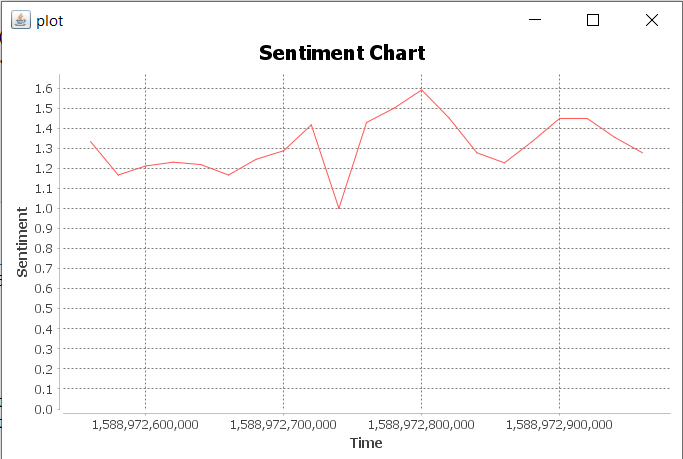

In [3]:
%%python
import matplotlib
matplotlib.use("agg")
from IPython.display import Image
with open("../Week 12/Output.PNG") as fo:
    retval = Image(filename=fo.name)